<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Random Forest Regression 
</p>

In [39]:
# Libraries for data manipulation and visualization
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.model_selection import PredefinedSplit, learning_curve
from scipy.stats import linregress

import time

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Dataset: Load Splits 
</p>

In [40]:
# Time-aware data load (from Data Preparation.ipynb outputs)

base_path = '../../Comprehensive ML - Files & Plots etc'

df_train = pd.read_csv(f"{base_path}/train.csv", parse_dates=['time'])
df_test  = pd.read_csv(f"{base_path}/test.csv", parse_dates=['time'])
fold_assignments = np.load(f"{base_path}/train_folds.npy")

feature_names = [
    'distance', 'frequency', 'c_walls', 'w_walls', 'co2', 'humidity',
    'pm25', 'pressure', 'temperature', 'snr'
]

X_train = df_train[feature_names].to_numpy()
y_train = df_train['PL'].to_numpy()
X_test  = df_test[feature_names].to_numpy()
y_test  = df_test['PL'].to_numpy()

time_train = df_train['time'].to_numpy()
time_test  = df_test['time'].to_numpy()

ps = PredefinedSplit(fold_assignments)  # reuse the time-aware folds

print(f"Train: {len(df_train)} rows, Test: {len(df_test)} rows")
print(f"Train window: {df_train.time.min()} -> {df_train.time.max()}")
print(f"Test window:  {df_test.time.min()} -> {df_test.time.max()}")

Train: 1663627 rows, Test: 415907 rows
Train window: 2024-10-01 00:01:07.420593+00:00 -> 2025-08-12 17:18:53.293125+00:00
Test window:  2025-08-12 17:19:02.126782+00:00 -> 2025-09-30 23:59:55.971870+00:00


In [41]:
# use a fraction of the data (keeps time order) *per fold*. Set USE_SUBSET=False for full data.
USE_SUBSET = False
DATA_FRACTION = 0.20  # fraction of data to keep from each fold

if USE_SUBSET:
    fold_ids = np.unique(fold_assignments[fold_assignments != -1])
    keep_mask = np.zeros(len(df_train), dtype=bool)
    kept_counts = {}

    # keep the first DATA_FRACTION portion within each fold, preserving order
    for fid in fold_ids:
        idx = np.flatnonzero(fold_assignments == fid)
        keep_n = max(1, int(np.ceil(len(idx) * DATA_FRACTION)))
        keep_mask[idx[:keep_n]] = True
        kept_counts[fid] = keep_n

    # (optional) if there are -1 labels in train, subset them too
    if np.any(fold_assignments == -1):
        idx = np.flatnonzero(fold_assignments == -1)
        keep_n = max(1, int(np.ceil(len(idx) * DATA_FRACTION)))
        keep_mask[idx[:keep_n]] = True
        kept_counts['-1'] = keep_n

    df_train = df_train.iloc[keep_mask].copy()
    fold_assignments = fold_assignments[keep_mask]
    # subset test set separately if you still want a fraction
    n_test = max(1, int(np.ceil(len(df_test) * DATA_FRACTION)))
    df_test = df_test.iloc[:n_test].copy()

    print("Using subset per fold:", kept_counts)
    print(f"Train rows kept: {len(df_train)}, Test rows kept: {len(df_test)}")
else:
    print("Using full dataset")

if len(df_train) == 0 or len(df_test) == 0:
    raise ValueError("Subset produced empty data; increase DATA_FRACTION or disable USE_SUBSET.")

# refresh arrays/split objects
X_train = df_train[feature_names].to_numpy()
y_train = df_train["PL"].to_numpy()
X_test = df_test[feature_names].to_numpy()
y_test = df_test["PL"].to_numpy()
time_train = df_train["time"].to_numpy()
time_test = df_test["time"].to_numpy()
ps = PredefinedSplit(fold_assignments)

fold_ids = fold_assignments[fold_assignments != -1]
print("Unique CV fold labels:", np.unique(fold_ids), "count:", np.unique(fold_ids).size)
print("Counts per fold:", np.bincount(fold_ids) if fold_ids.size else "none")

Using full dataset
Unique CV fold labels: [0 1 2 3 4] count: 5
Counts per fold: [554543 277271 277271 277271 277271]


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Define Bayesian Search Space and Model Helper
</p>

In [ ]:
# param space for Bayesian optimization
search_spaces = {
    'n_estimators': Integer(100, 300),
    'max_depth': Integer(2, 10),  # Keep bounded; higher risks noise in large data
    'min_samples_split': Integer(50, 200),  # Higher min to generalize, avoid splits on noise
    'min_samples_leaf': Integer(50, 1000),  # Widen upper for stronger regularization on M+ samples
    'max_samples': Real(0.6, 0.9),  # Fraction of data per tree; <1.0 reduces overfitting
    'min_impurity_decrease': Real(0.001, 0.1, prior='log-uniform')  # Stronger reg range
}

def create_rf_model():
    return RandomForestRegressor(
        criterion='squared_error',
        max_features='log2',
        random_state=50,
        n_jobs=3,  # Parallelism handled by BayesSearchCV
        min_impurity_decrease=0.01,  # Keeps splits meaningful
        bootstrap=True,
        oob_score=True  # For OOB validation to monitor overfitting
    )

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Bayesian SearchCV with Custom Folds & Analysis Per-Depth Results 
</p>

In [43]:
# Setup for multi-metric scoring 
scoring = {
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

#  PredefinedSplit for time-ordered CV 
ps = PredefinedSplit(fold_assignments)

# Bayesian optimization, scoring on both RMSE and R² 
bayes_cv = BayesSearchCV(
    estimator=create_rf_model(),  # function for RF config
    search_spaces=search_spaces,
    n_iter=20,  # or as desired
    scoring=scoring,
    refit='neg_root_mean_squared_error',  # selects best by RMSE
    n_jobs=8,
    cv=ps,
    random_state=42,
    verbose=1,
    n_points=3,  # parallel evaluations per iteration
    optimizer_kwargs={'n_initial_points': 10, 'acq_func': 'gp_hedge'}  # More initial randoms; robust acquisition
)

# Suppress skopt UserWarnings about repeated evaluation of the same hyperparameter set
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='skopt')

print(f"Starting Bayesian optimization with {bayes_cv.n_iter} iterations "
      f"and {ps.get_n_splits()}-fold cross-validation per candidate...\n")

# Fit Bayesian optimizer on training data 
t0 = time.time()
bayes_cv.fit(X_train, y_train) 
t1 = time.time()
print(f"\nBayesian optimization complete in {(t1 - t0)/60:.2f} minutes.")

print("\nExtracting results...")

# Pull all tried configs/results into a dataframe 
bayes_results = pd.DataFrame(bayes_cv.cv_results_)
print(f"\nTried {bayes_results.shape[0]} configurations.")

# Save full CV results
cv_results_path = "Results/bayes_cv_results.csv"
bayes_results.to_csv(cv_results_path, index=False)
print(f"\nSaved BayesSearchCV cv_results_ to: {cv_results_path}")

Starting Bayesian optimization with 20 iterations and 5-fold cross-validation per candidate...

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END max_depth=5, max_samples=0.8218512702571261, min_impurity_decrease=0.004063746627400018, min_samples_leaf=665, min_samples_split=132, n_estimators=125; total time= 1.5min
[CV] END max_depth=5, max_samples=0.8218512702571261, min_impurity_decrease=0.004063746627400018, min_samples_leaf=665, min_samples_split=132, n_estimators=125; total time= 1.9min
[CV] END max_depth=5, max_samples=0.8218512702571261, min_impurity_decrease=0.004063746627400018, min_samples_leaf=665, min_samples_split=132, n_estimators=125; total time= 1.9min
[CV] END max_depth=5, max_samples=0.8183177229531975, min_impurity_decrease=0.07340675018434775, min_samples_leaf=350, min_samples_split=151, n_estimators=183; total time= 1.9min
[CV] END max_depth=5, max_samples=0.8183177229531975, min_impurity_decrease=0.07340675018434775, min_samples_leaf=350, min_sa

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Summarize best CV results for each max_depth
</p>

In [44]:
# Best-per-depth summary + cv_df for plotting
if 'bayes_results' not in locals() or bayes_results.empty:
    print("Run BayesSearchCV cell first.")
else:
    param_cols = [c.split('param_')[1] for c in bayes_results.columns if c.startswith('param_')]
    rows = []
    for d in sorted(bayes_results['param_max_depth'].dropna().unique()):
        df_d = bayes_results[bayes_results['param_max_depth'] == d]
        idx = df_d['mean_test_neg_root_mean_squared_error'].idxmax()
        r = df_d.loc[idx]
        row = {
            'max_depth': d,
            'best_cv_rmse': -r['mean_test_neg_root_mean_squared_error'],
            'std_cv_rmse': r['std_test_neg_root_mean_squared_error'],
            'best_cv_r2': r['mean_test_r2'],
            'std_cv_r2': r['std_test_r2'],
        }
        for p in param_cols:
            row[p] = r[f'param_{p}']
        rows.append(row)

    cv_df = pd.DataFrame(rows).sort_values('max_depth')

    # Best-per-depth table (transposed)
    tbl = cv_df.copy()
    num_cols = tbl.select_dtypes(include='number').columns
    tbl[num_cols] = tbl[num_cols].round(4)

    tbl_t = tbl.set_index('max_depth').T
    tbl_t.index.name = 'metric/param'
    tbl_t.columns = [f"max_depth={int(c)}" for c in tbl_t.columns]
    display(tbl_t)

,max_depth=2,max_depth=3,max_depth=4,max_depth=5,max_depth=6,max_depth=7,max_depth=8,max_depth=9,max_depth=10
metric/param,,,,,,,,,
best_cv_rmse,9.7290,7.9836,6.9191,6.4669,6.0780,5.9088,5.8534,5.8384,5.9848
std_cv_rmse,0.5591,0.5751,0.5921,0.5205,0.5132,0.4910,0.4605,0.4270,0.3656
best_cv_r2,0.7307,0.8182,0.8627,0.8802,0.8940,0.8997,0.9016,0.9020,0.8972
std_cv_r2,0.0209,0.0222,0.0242,0.0194,0.0189,0.0187,0.0184,0.0180,0.0170
max_samples,0.6588,0.7896,0.7529,0.8219,0.8756,0.6000,0.9000,0.6000,0.9000
min_impurity_decrease,0.0011,0.0014,0.0078,0.0041,0.0016,0.0010,0.0010,0.0010,0.0010
min_samples_leaf,999.0000,683.0000,393.0000,665.0000,462.0000,50.0000,50.0000,50.0000,1000.0000
min_samples_split,125.0000,152.0000,200.0000,132.0000,78.0000,200.0000,200.0000,50.0000,200.0000
n_estimators,295.0000,254.0000,146.0000,125.0000,191.0000,300.0000,300.0000,100.0000,100.0000


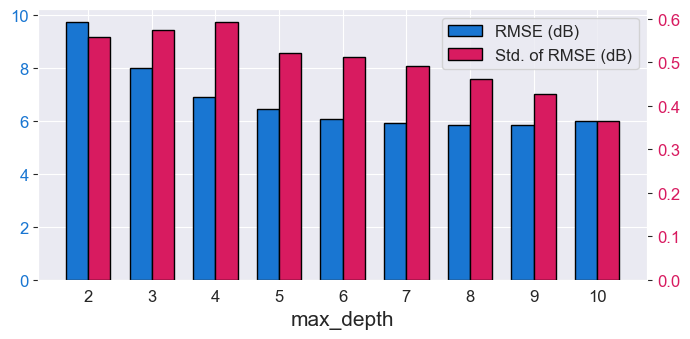

In [45]:
#  FONT SIZE METRICS 
tick_fontsize = 12         # Tick label size
axis_labelsize = 15        # Axis label size
legend_fontsize = 12       # Legend font size

sns.set_style("darkgrid")

x = np.arange(len(cv_df['max_depth']))
bar_width = 0.35

fig, ax1 = plt.subplots(figsize=(7, 3.5))

# Blue bars: Best CV RMSE (left y-axis)
bars1 = ax1.bar(
    x - bar_width/2, 
    cv_df['best_cv_rmse'], 
    bar_width, 
    color='#1976d2',
    label='RMSE',
    edgecolor='black',
    linewidth=1,
    zorder=3
)
#ax1.set_ylabel('RMSE (dB)', color='#1976d2', fontsize=axis_labelsize)
ax1.set_xlabel('max_depth', fontsize=axis_labelsize)
ax1.set_xticks(x)
ax1.set_xticklabels(cv_df['max_depth'], fontsize=tick_fontsize)
ax1.tick_params(axis='y', labelcolor='#1976d2', labelsize=tick_fontsize)
ax1.grid(True, axis='y')

# Magenta bars: STD of CV RMSE (right y-axis), offset to right
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + bar_width/2, 
    cv_df['std_cv_rmse'], 
    bar_width, 
    color='#d81b60',
    label='Std. of RMSE',
    edgecolor='black',
    linewidth=1,
    zorder=3
)
#ax2.set_ylabel('Std. of RMSE (dB)', color='#d81b60', fontsize=axis_labelsize)
ax2.tick_params(axis='y', labelcolor='#d81b60', labelsize=tick_fontsize)
ax2.grid(False)

# Single legend
handles = [
    plt.Rectangle((0,0),1,1,color='#1976d2',ec='black',label='RMSE (dB)'),
    plt.Rectangle((0,0),1,1,color='#d81b60',ec='black',label='Std. of RMSE (dB)')
]
ax1.legend(handles=handles, loc='upper right', fontsize=legend_fontsize)

fig.tight_layout()
plt.savefig('../../Comprehensive ML - Files & Plots etc/RF_bestRMSE_&_STD_perDepth.png', dpi=2000, bbox_inches='tight')
plt.show()

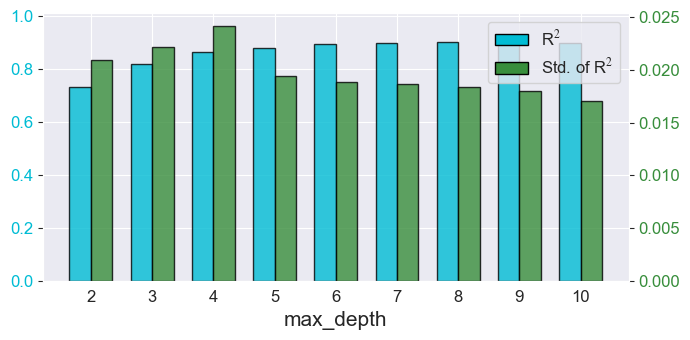

In [46]:
# ---- FONT SIZE METRICS ----
tick_fontsize = 12         # Tick label size
axis_labelsize = 15        # Axis label size
legend_fontsize = 12       # Legend font size

sns.set_style("darkgrid")

x = np.arange(len(cv_df['max_depth']))
bar_width = 0.35

fig, ax1 = plt.subplots(figsize=(7, 3.5))

# --- Cyan bars: Best CV R² (left y-axis) ---
bars1 = ax1.bar(
    x - bar_width/2, 
    cv_df['best_cv_r2'], 
    bar_width, 
    color='#00bcd4',                # Cyan
    edgecolor='black',
    linewidth=1,
    alpha=0.8,
    label='R$^2$'
)
ax1.set_xlabel('max_depth', fontsize=axis_labelsize)
#ax1.set_ylabel('Best CV R$^2$', color='#00bcd4', fontsize=axis_labelsize)
ax1.set_xticks(x)
ax1.set_xticklabels(cv_df['max_depth'], fontsize=tick_fontsize)
ax1.tick_params(axis='y', labelcolor='#00bcd4', labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)
ax1.set_ylim(0, 1.01)
ax1.grid(True, axis='y')

# --- Green bars: STD of CV R² (right y-axis) ---
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + bar_width/2, 
    cv_df['std_cv_r2'], 
    bar_width, 
    color='#388e3c',                # Green
    edgecolor='black',
    linewidth=1,
    alpha=0.8,
    label='Std. of R$^2$'
)
#ax2.set_ylabel('Std. of CV R$^2$', color='#388e3c', fontsize=axis_labelsize)
ax2.tick_params(axis='y', labelcolor='#388e3c', labelsize=tick_fontsize)
ax2.grid(False)

# --- Combined Legend (top right, inside) ---
handles = [
    plt.Rectangle((0,0),1,1,color='#00bcd4',ec='black',label='R$^2$'),
    plt.Rectangle((0,0),1,1,color='#388e3c',ec='black',label='Std. of R$^2$')
]
ax1.legend(handles=handles, loc='upper right', fontsize=legend_fontsize)

fig.tight_layout()
#plt.savefig('../../Comprehensive ML - Files & Plots etc/RF_bestR2_STD_perDepth.png', dpi=2000, bbox_inches='tight')
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Train on All Training Data and Test Evaluation 
</p>

In [47]:
# Use built-in best_estimator_ (already refitted on full train data) and best_params_
best_model = bayes_cv.best_estimator_
best_params = bayes_cv.best_params_
print("Best Parameters Found:", best_params)

print("\nUsing best model from BayesSearchCV (already trained on all data)...")

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_median_ae = median_absolute_error(y_test, y_test_pred)

results = pd.DataFrame({
    'Metric': [
        'Training Loss (MSE)', 'Test Loss (MSE)', 'Test RMSE',
        'R² Score (Train)', 'R² Score (Test)', 'Test MAPE (%)', 'Test Median AE'
    ],
    'Value': [
        train_mse, test_mse, test_rmse, train_r2, test_r2,
        test_mape * 100, test_median_ae
    ]
})

print("\nModel Evaluation Metrics:")
display(results)

Best Parameters Found: OrderedDict({'max_depth': 9, 'max_samples': 0.6, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 100})

Using best model from BayesSearchCV (already trained on all data)...

Model Evaluation Metrics:


,Metric,Value
0,Training Loss (MSE),23.041012
1,Test Loss (MSE),26.198966
2,Test RMSE,5.118493
3,R² Score (Train),0.934918
4,R² Score (Test),0.926098
5,Test MAPE (%),4.418259
6,Test Median AE,3.108479


In [48]:
# Ensure the directory exists
os.makedirs('Models', exist_ok=True)

# Save the trained Random Forest model
with open('../Models/rf_final_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Trained Random Forest model saved to Models/rf_final_model.pkl")

Trained Random Forest model saved to Models/rf_final_model.pkl


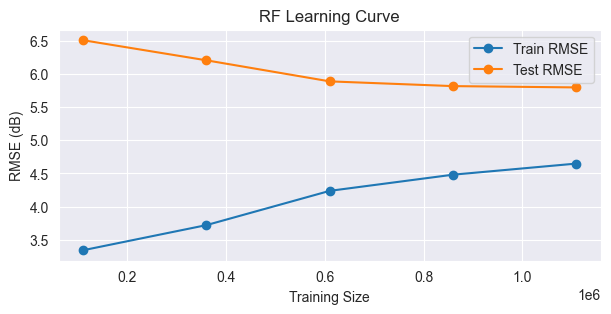

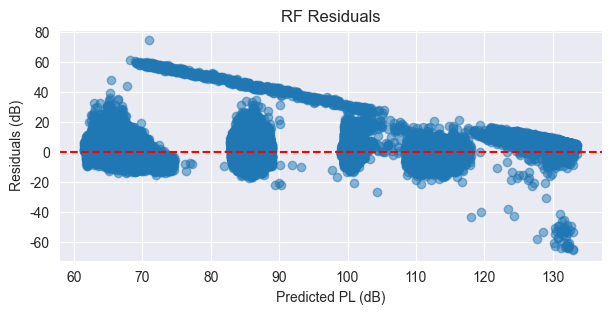

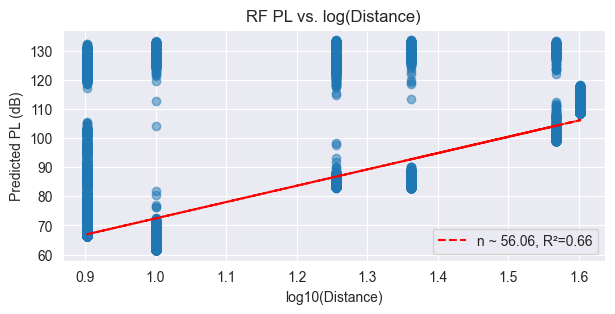

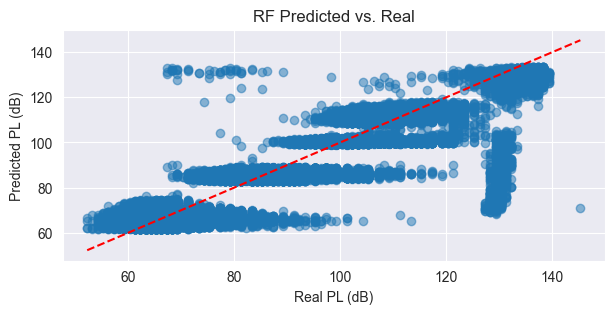

In [49]:
rf_model = best_model  # Already available

figsize = (7, 3)
path = '../../Comprehensive ML - Files & Plots etc/'

# 1. Learning Curve
train_sizes, train_scores, test_scores = learning_curve(rf_model, X_train, y_train, cv=ps, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5), scoring='neg_root_mean_squared_error')
train_rmse = -train_scores.mean(1)
test_rmse = -test_scores.mean(1)
plt.figure(figsize=figsize)
plt.plot(train_sizes, train_rmse, 'o-', label='Train RMSE')
plt.plot(train_sizes, test_rmse, 'o-', label='Test RMSE')
plt.xlabel('Training Size')
plt.ylabel('RMSE (dB)')
plt.title('RF Learning Curve')
plt.legend()
#plt.savefig(f'{path}RF_learning_curve.png', dpi=300)
plt.show()

# 2. Residuals
y_test_pred = rf_model.predict(X_test)
residuals = y_test - y_test_pred
plt.figure(figsize=figsize)
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted PL (dB)')
plt.ylabel('Residuals (dB)')
plt.title('RF Residuals')
#plt.savefig(f'{path}RF_residuals.png', dpi=300)
plt.show()

# 3. Physics Consistency (PL vs. log(distance))
dist = df_test['distance'].values
log_dist = np.log10(dist + 1e-6)
slope, intercept, r_value, _, _ = linregress(log_dist, y_test_pred)
plt.figure(figsize=figsize)
plt.scatter(log_dist, y_test_pred, alpha=0.5)
plt.plot(log_dist, intercept + slope * log_dist, 'r--', label=f'n ~ {slope:.2f}, R²={r_value**2:.2f}')
plt.xlabel('log10(Distance)')
plt.ylabel('Predicted PL (dB)')
plt.title('RF PL vs. log(Distance)')
plt.legend()
#plt.savefig(f'{path}RF_physics_consistency.png', dpi=300)
plt.show()

# 4. Predicted vs. Real
plt.figure(figsize=figsize)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Real PL (dB)')
plt.ylabel('Predicted PL (dB)')
plt.title('RF Predicted vs. Real')
#plt.savefig(f'{path}RF_pred_vs_real.png', dpi=300)
plt.show()